In [ ]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
from meep_material import lorentzfit

In [ ]:
resolution = 100
nfreq = 300
fcen = 1.75
df = 3.3

In [3]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.4, fit_wl_max=0.7,
                   num_lorentzians=2, iteration=30):    
        data          = np.genfromtxt(Material_data_csv, delimiter=",")
        wl            = data[:, 0]                    # 파장 (μm)
        eps_total     = data[:, 1] + 1j*data[:, 2]     # 이미 permittivity

        # --- 3) 피팅 범위 설정 ---
        eps_inf   = 1.1
        wl_min, wl_max = 0.4, 0.7
        mask      = (wl >= wl_min) & (wl <= wl_max)
        wl_red    = wl[mask]
        freqs_red = 1.0 / wl_red
        eps_fit_target = eps_total[mask] - eps_inf

        # --- 4) Lorentz-Drude 피팅 (생략: 기존 lorentzfit 사용) ---
        num_L, num_rep = num_lorentzians, iteration

        ps   = np.zeros((num_rep, 3*num_L))
        errs = np.zeros(num_rep)
        for i in range(num_rep):
            p0 = [10**np.random.uniform(2,5) for _ in range(3*num_L)]
            ps[i], errs[i] = lorentzfit(p0, freqs_red, eps_fit_target,
                                        nlopt.LD_MMA, 1e-25, 50000)
            print(f"Iteration {i:3d}, error: {errs[i]:.6f}")                                   
        best = np.argmin(errs)
        p_opt = ps[best]
        print(f"Optimal error: {errs[best]:.6f}")

        # --- 5) Meep Medium 생성 (수정된 부분) ---
        suscept = []
        for j in range(num_L):
            ω = p_opt[3*j + 1]
            γ = p_opt[3*j + 2]
            if ω == 0:
                σ = p_opt[3*j + 0]
                suscept.append(
                    mp.DrudeSusceptibility(
                        frequency=1.0,
                        gamma=γ,
                        sigma=σ
                    )
                )
            else:
                σ = p_opt[3*j + 0] / ω**2
                suscept.append(
                    mp.LorentzianSusceptibility(
                        frequency=ω,
                        gamma=γ,
                        sigma=σ
                    )
                )
    
        return eps_inf, suscept
    
sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/Material data/sio2_material_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/merged_al_eps.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/merged_aNDP_eps.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.001686
Iteration   1, error: 0.001772
Iteration   2, error: 0.001446
Iteration   3, error: 0.001776
Iteration   4, error: 0.001522
Iteration   5, error: 0.001788
Iteration   6, error: 0.001762
Iteration   7, error: 0.001736
Iteration   8, error: 0.001749
Iteration   9, error: 0.001783
Iteration  10, error: 0.001758
Iteration  11, error: 0.001610
Iteration  12, error: 0.001778
Iteration  13, error: 0.001781
Iteration  14, error: 0.001749
Iteration  15, error: 0.001774
Iteration  16, error: 0.001757
Iteration  17, error: 0.001777
Iteration  18, error: 0.001321
Iteration  19, error: 0.001785
Iteration  20, error: 0.001770
Iteration  21, error: 0.001781
Iteration  22, error: 0.001721
Iteration  23, error: 0.001731
Iteration  24, error: 0.001636
Iteration  25, error: 0.001786
Iteration  26, error: 0.001783
Iteration  27, error: 0.001746
Iteration  28, error: 0.001786
Iteration  29, error: 0.001783
Optimal error: 0.001321
Iteration   0, error: 2100240.875849
Iteration

In [ ]:
### ----- Refractive index ----- ###,
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 ,
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP ,
Cathode = mp.Medium(epsilon = eps_inf_al, E_susceptibilities = suscept_al)

# Cathode = mp.perfect_electric_conductor,

CoverLayer = mp.Medium(index=1.9) # SiN ,
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기,

Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

PML_layer = 0.5

boundary_layers = [
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.Low),  # 좌측 PML,
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.High), # 우측 PML,
    mp.PML(thickness=PML_layer, direction=mp.Y, side=mp.High), # 상단 PML,
]

Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)

In [5]:
cell_size = mp.Vector3(31, 2, 0)

geometry_fitting_Al = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(mp.inf, Cathode_layer, 0),
            material=Cathode
        ),
        # Alq3
        mp.Block(
            center=Alq3_center,
            size=mp.Vector3(mp.inf, Alq3_layer, 0),
            material=Alq3
        ),
        # aNDP
        mp.Block(
            center=aNDP_center,
            size=mp.Vector3(mp.inf, aNDP_layer, 0),
            material=aNDP
        ),
        # ITO
        mp.Block(
            center=ITO_center,
            size=mp.Vector3(mp.inf, ITO_layer, 0),
            material=ITO_m
        ),
        # Cover layer
        mp.Block(
            center=Cover_center,
            size=mp.Vector3(mp.inf, Cover_layer, 0),
            material=CoverLayer
        ),
        # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        mp.Block(
            center=Glass_center,
            size=mp.Vector3(mp.inf, Glass_layer, 0),
            material=Glass
        )
]

source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=mp.Ex,
        center=source_center,
        size=mp.Vector3(0,0,0),
        amplitude = 0.1
)]

In [11]:
# === 시뮬레이션 설정 === #
sim_fitting_Al = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry_fitting_Al[:1],
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
    extra_materials=[Cathode, Alq3, aNDP, ITO_m, CoverLayer, Glass]
)

     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)


<Axes: xlabel='X', ylabel='Y'>

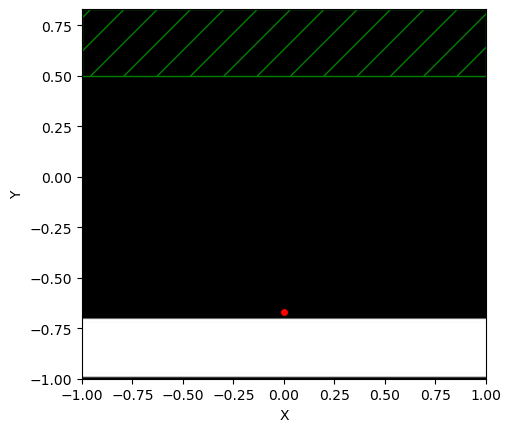

In [12]:
sim_fitting_Al.plot2D(output_plane = mp.Volume(center=mp.Vector3(0, -0.67, 0), size=mp.Vector3(2, 3, 0)))

In [13]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power_fitting_Al = sim_fitting_Al.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X
                ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

# sim_fitting_Al.run(until_after_sources = mp.stop_when_fields_decayed(1e-5, mp.Ex, source_center, 0), until = 200)

sim_fitting_Al.run(until = 10)
net_power_fitting_al = mp.get_fluxes(box_power_fitting_Al)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000334978 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.396442 s
lorentzian susceptibility: frequency=26.8826, gamma=0
lorentzian susceptibility: frequency=56010.6, gamma=257.502
lorentzian susceptibility: frequency=97799, gamma=916.988
lorentzian susceptibility: frequency=3.72617, gamma=0.210483
lorentzian susceptibility: frequency=2914.88, gamma=92341.2
drude susceptibility: frequency=1, gamma=0.5599
-----------


RuntimeError: meep: simulation fields are NaN or Inf

### resolution 1000 - air(sourcepower)

In [ ]:
from src_resolution import sourcepower

src_wavelengths, src_power = sourcepower(100)

In [ ]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/RESOLUTION/full/full_100.txt")

# CSV 파일 불러오기
lumerical_data = np.genfromtxt(csv_path, delimiter=",")

lumerical = lumerical_data[:, 1]

In [ ]:
# lumerical data import
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/ldos_sourcepower_res100.csv")

# CSV 파일 불러오기
air_1000_data = np.genfromtxt(csv_path, delimiter=",", skip_header=1)

air_1000 = air_1000_data[:, 1]

In [ ]:
# dp_box / sourcepower 정규화
dp_fitting_al = net_power_fitting_al / src_power

plt.figure(figsize=(8, 8))

# plot 순서
plt.plot(wavelengths, dp_fitting_al, label='Meep_dp_box', color='red')
plt.plot(wavelengths, lumerical, label='Lumerical_dp_box', color='blue')
# plt.plot(wavelength_sliced_al_nofunc, Al_power_sliced_nofunc, label='Lumerical dp', color='green')


# 축 레이블 (굵게 + 크기 조정)
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("dp = net_power / source_power", fontsize=20)

# 제목 (굵게 + 크기 조정)
plt.title("Normalized Dipole Power", fontsize=24)

# 눈금 폰트 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 범례 (폰트 크기 조정 + 굵게)
plt.legend(fontsize=20, frameon=True,)

# 기타 설정
plt.grid(True)
plt.tight_layout()
# plt.ylim([0, 1.5])
plt.xlim([0.4, 0.7])
plt.show()

In [ ]:
# === Relative Error 계산 === #
relative_error = np.abs((dp_fitting_al - lumerical) / lumerical)* 100

# relative_error_nofunc = np.abs((Al_power_sliced_nofunc - dp_fitting_al) / dp_fitting_al)* 100


# === Relative Error 플롯 === #
plt.figure(figsize=(8, 8))
plt.plot(wavelengths, relative_error, label='Relative Error', color='purple')
# plt.plot(wavelengths, relative_error_nofunc, label='Relative Error dp_box', color='cyan')


# 축 레이블
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("Relative Error (%)", fontsize=20)

# 제목
plt.title("Relative Error: Lumerical vs Meep (Al)", fontsize=24)

# 눈금, 범례
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.xlim([0.4, 0.7])
plt.show()
